## Importations

In [1]:
## plots
import matplotlib.pyplot as plt
from matplotlib import rc

##
import seaborn as sns

import sys
sys.path.append('../')

## ML :
from scripts.machine_learning_utils import *
from scripts.models import *
from scripts.descriptors import *

rc('font', family='sans-serif', size = 7)
rc('figure', dpi= 700)
rc(('xtick', 'ytick'), labelsize = 7)
rc('legend', fontsize=6)
rc('lines', linewidth = 1)
rc('axes', linewidth = 0.5, labelsize =8)
rc('legend', handlelength = 2)

from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV

from sklearn.feature_selection import r_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import ShuffleSplit
from sklearn.pipeline import make_pipeline



Skipped loading some PyTorch models, missing a dependency. No module named 'torch'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch'
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'torch'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


## Get data

In [2]:
df_total = pd.read_csv('../tables/data/df_total.csv').set_index('SMILES')

In [3]:
df_ONO_train = pd.read_csv("../tables/data/ONO_train_set.csv").set_index('SMILES')
df_ONO_test = pd.read_csv("../tables/data/ONO_test_set.csv").set_index('SMILES')

### Create concatenated descriptors

In [5]:
df = df_ONO_train
X_rdkit = create_descriptors(df.index, "rdkit")
X_hammett = create_descriptors(df.index, "hammett", structure = 'ONO')
X_rdkit_hammett = np.concatenate((X_rdkit, X_hammett), axis = 1)


In [15]:
X_rdkit_train = create_descriptors(df_ONO_train.index, "rdkit")
X_hammett_train = create_descriptors(df_ONO_train.index, "hammett", structure = 'ONO')
X_rdkit_hammett_ONO_train = np.concatenate((X_rdkit_train, X_hammett_train), axis = 1)

X_rdkit_test = create_descriptors(df_ONO_test.index, "rdkit")
X_hammett_test = create_descriptors(df_ONO_test.index, "hammett", structure = 'ONO')
X_rdkit_hammett_ONO_test = np.concatenate((X_rdkit_test, X_hammett_test), axis = 1)

Y_train = df_ONO_train.FIA
Y_test = df_ONO_test.FIA

Get names of descriptors

## Feature selection

In [ ]:
select_feat = SelectKBest(f_regression, k = 126 )
select_feat.fit(X_rdkit_hammett_ONO_train, Y_train)

In [ ]:
names_rdkit_hammett = get_names('rdkit') + get_names('hammett')

In [ ]:
selected_features = select_feat.get_feature_names_out(names_rdkit_hammett)
selected_features

array(['MaxEStateIndex', 'MinEStateIndex', 'MaxAbsEStateIndex', 'qed',
       'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons',
       'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge',
       'MinAbsPartialCharge', 'FpDensityMorgan3', 'BCUT2D_MWHI',
       'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW',
       'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'BalabanJ', 'BertzCT', 'Chi0',
       'Chi1', 'Chi2n', 'Chi3v', 'Chi4v', 'HallKierAlpha', 'Ipc',
       'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1',
       'PEOE_VSA10', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14',
       'PEOE_VSA2', 'PEOE_VSA4', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9',
       'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA5', 'SMR_VSA6',
       'SMR_VSA7', 'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA11',
       'SlogP_VSA12', 'SlogP_VSA2', 'SlogP_VSA4', 'SlogP_VSA6',
       'SlogP_VSA7', 'TPSA', 'EState_VSA1', 'EState_VSA10', 'EState_VSA2',
       'EState_VSA4', 'EState_VSA7', 'EState_V

In [16]:
def train_predict_oracle(X_train, X_validation, Y_train, Y_validation, model):
    var_selector =  VarianceThreshold()
    X_train = var_selector.fit_transform(X_train)
    X_validation = var_selector.transform(X_validation)
    scaler = StandardScaler().fit(X_train) ## descriptors are scaled
    X_train = scaler.transform(X_train)
    X_validation = scaler.transform(X_validation)    
    # it is very important to fit the preprocessing only 
    #on train data to avoid data leakage
    select_feat = SelectKBest(f_regression, k = 126 )
    X_train = select_feat.fit_transform(X_train, Y_train)
    X_validation = select_feat.transform(X_validation)
    
    model.fit(X_train, Y_train)
    Y_pred_test = model.predict(X_validation)
    MAE = mean_absolute_error(Y_validation, model.predict(X_validation))
    return(Y_pred_test,MAE)

def K_Fold_model_evaluation_oracle(model,X,Y,n_fold, n_repet):
    
    total_Y_validation = []
    total_Y_pred_validation = []
    list_MAE = []
    
    for i in range(n_repet):
        KF = KFold(n_splits=n_fold, shuffle=True)# do not fix the random state or it will give the same split for each n_rep
        for i, (train_index, validation_index) in enumerate(KF.split(X,Y)):
            X_train = X[train_index]
            X_validation = X[validation_index]
            Y_train = Y[train_index]
            Y_validation = Y[validation_index]

            Y_pred_test,MAE = train_predict(X_train, X_validation, Y_train, Y_validation, model)

            for elt in Y_validation :
                total_Y_validation.append(elt)
            for elt in Y_pred_test :
                total_Y_pred_validation.append(elt)
            
            list_MAE.append(MAE)    
    
    return(total_Y_validation, total_Y_pred_validation, list_MAE)

In [17]:
model = Ridge(alpha=0.7, solver='sparse_cg', tol=1e-06)

In [20]:
total_Y_validation, total_Y_pred_validation, list_MAE = K_Fold_model_evaluation_oracle(model,X_rdkit_hammett_ONO_train,Y_train,
                                                                    n_fold =10, n_repet = 10)
print('MAE on train set :', np.mean(list_MAE))

MAE on train set : 6.774226926012781


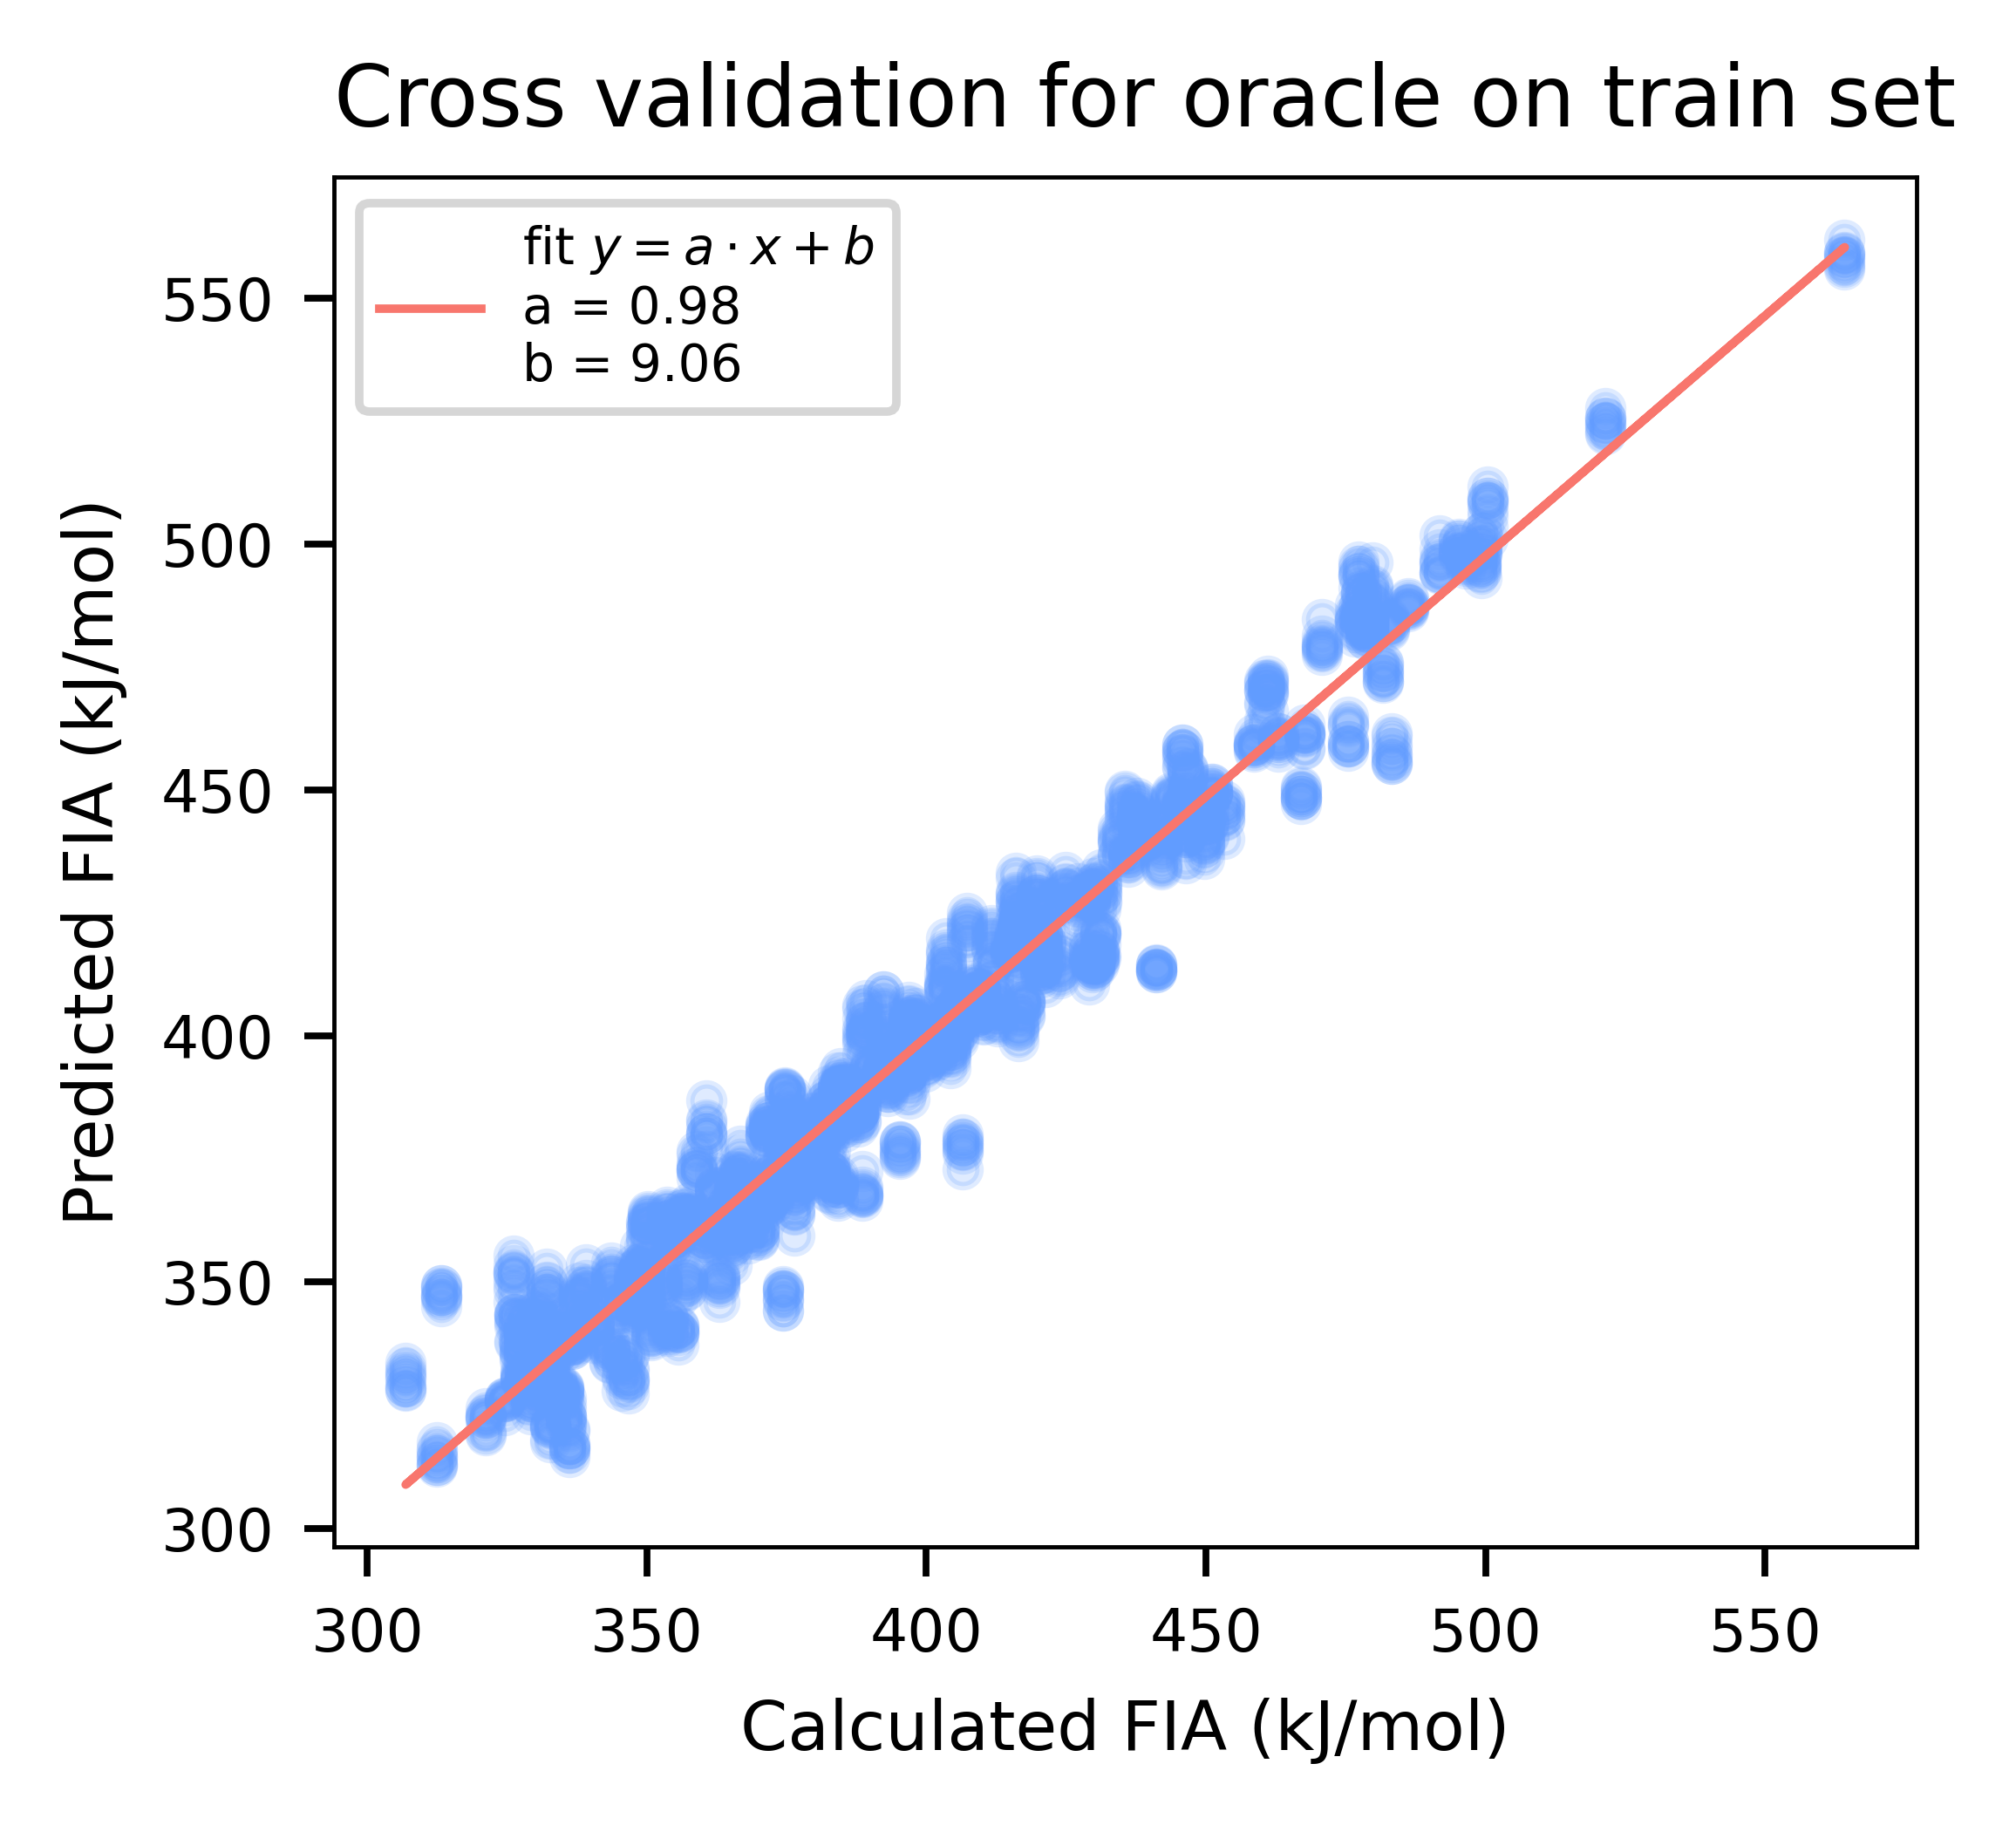

In [19]:

fig, ax = plt.subplots(figsize=(3.25, 3))

plt.ylabel('Predicted FIA (kJ/mol)')
plt.xlabel('Calculated FIA (kJ/mol)')


plt.scatter(x=total_Y_validation, y=total_Y_pred_validation, s = 15, c="#619CFF", alpha=0.2)


z = np.polyfit(total_Y_validation, total_Y_pred_validation, 1)
p = np.poly1d(z)
    
plt.plot(total_Y_validation,p(total_Y_validation),"#F8766D", label = f"fit $y=a \cdot x+b$ \na = {round(z[0],2)} \nb = {round(z[1],2)}")

ax.set_title('Cross validation for oracle on train set', loc='left', fontsize =10)
plt.tight_layout()
plt.legend()
plt.show()

## Performances on test set

In [22]:
scaler = StandardScaler().fit(X_rdkit_hammett_ONO_train) ## descriptors are scaled
X_train = scaler.transform(X_rdkit_hammett_ONO_train)
X_test = scaler.transform(X_rdkit_hammett_ONO_test)    
    # it is very important to fit the preprocessing only 
    #on train data to avoid data leakage
var_selector =  VarianceThreshold()
X_train = var_selector.fit_transform(X_train)
X_test = var_selector.transform(X_test)
    
f_selector = SelectKBest(f_regression, k = 126)
f_selector.fit(X_train, Y_train)
X_train = f_selector.transform(X_train) 
X_test = f_selector.transform(X_test)
    
model.fit(X_train, Y_train)
Y_pred_test = model.predict(X_test)
MAE = mean_absolute_error(Y_test, Y_pred_test)
R2= r2_score(Y_test, Y_pred_test)

print('MAE on test set :', MAE)
print('R2 on test set :', R2)

MAE on test set : 5.391334579491825
R2 on test set : 0.9781640773767364


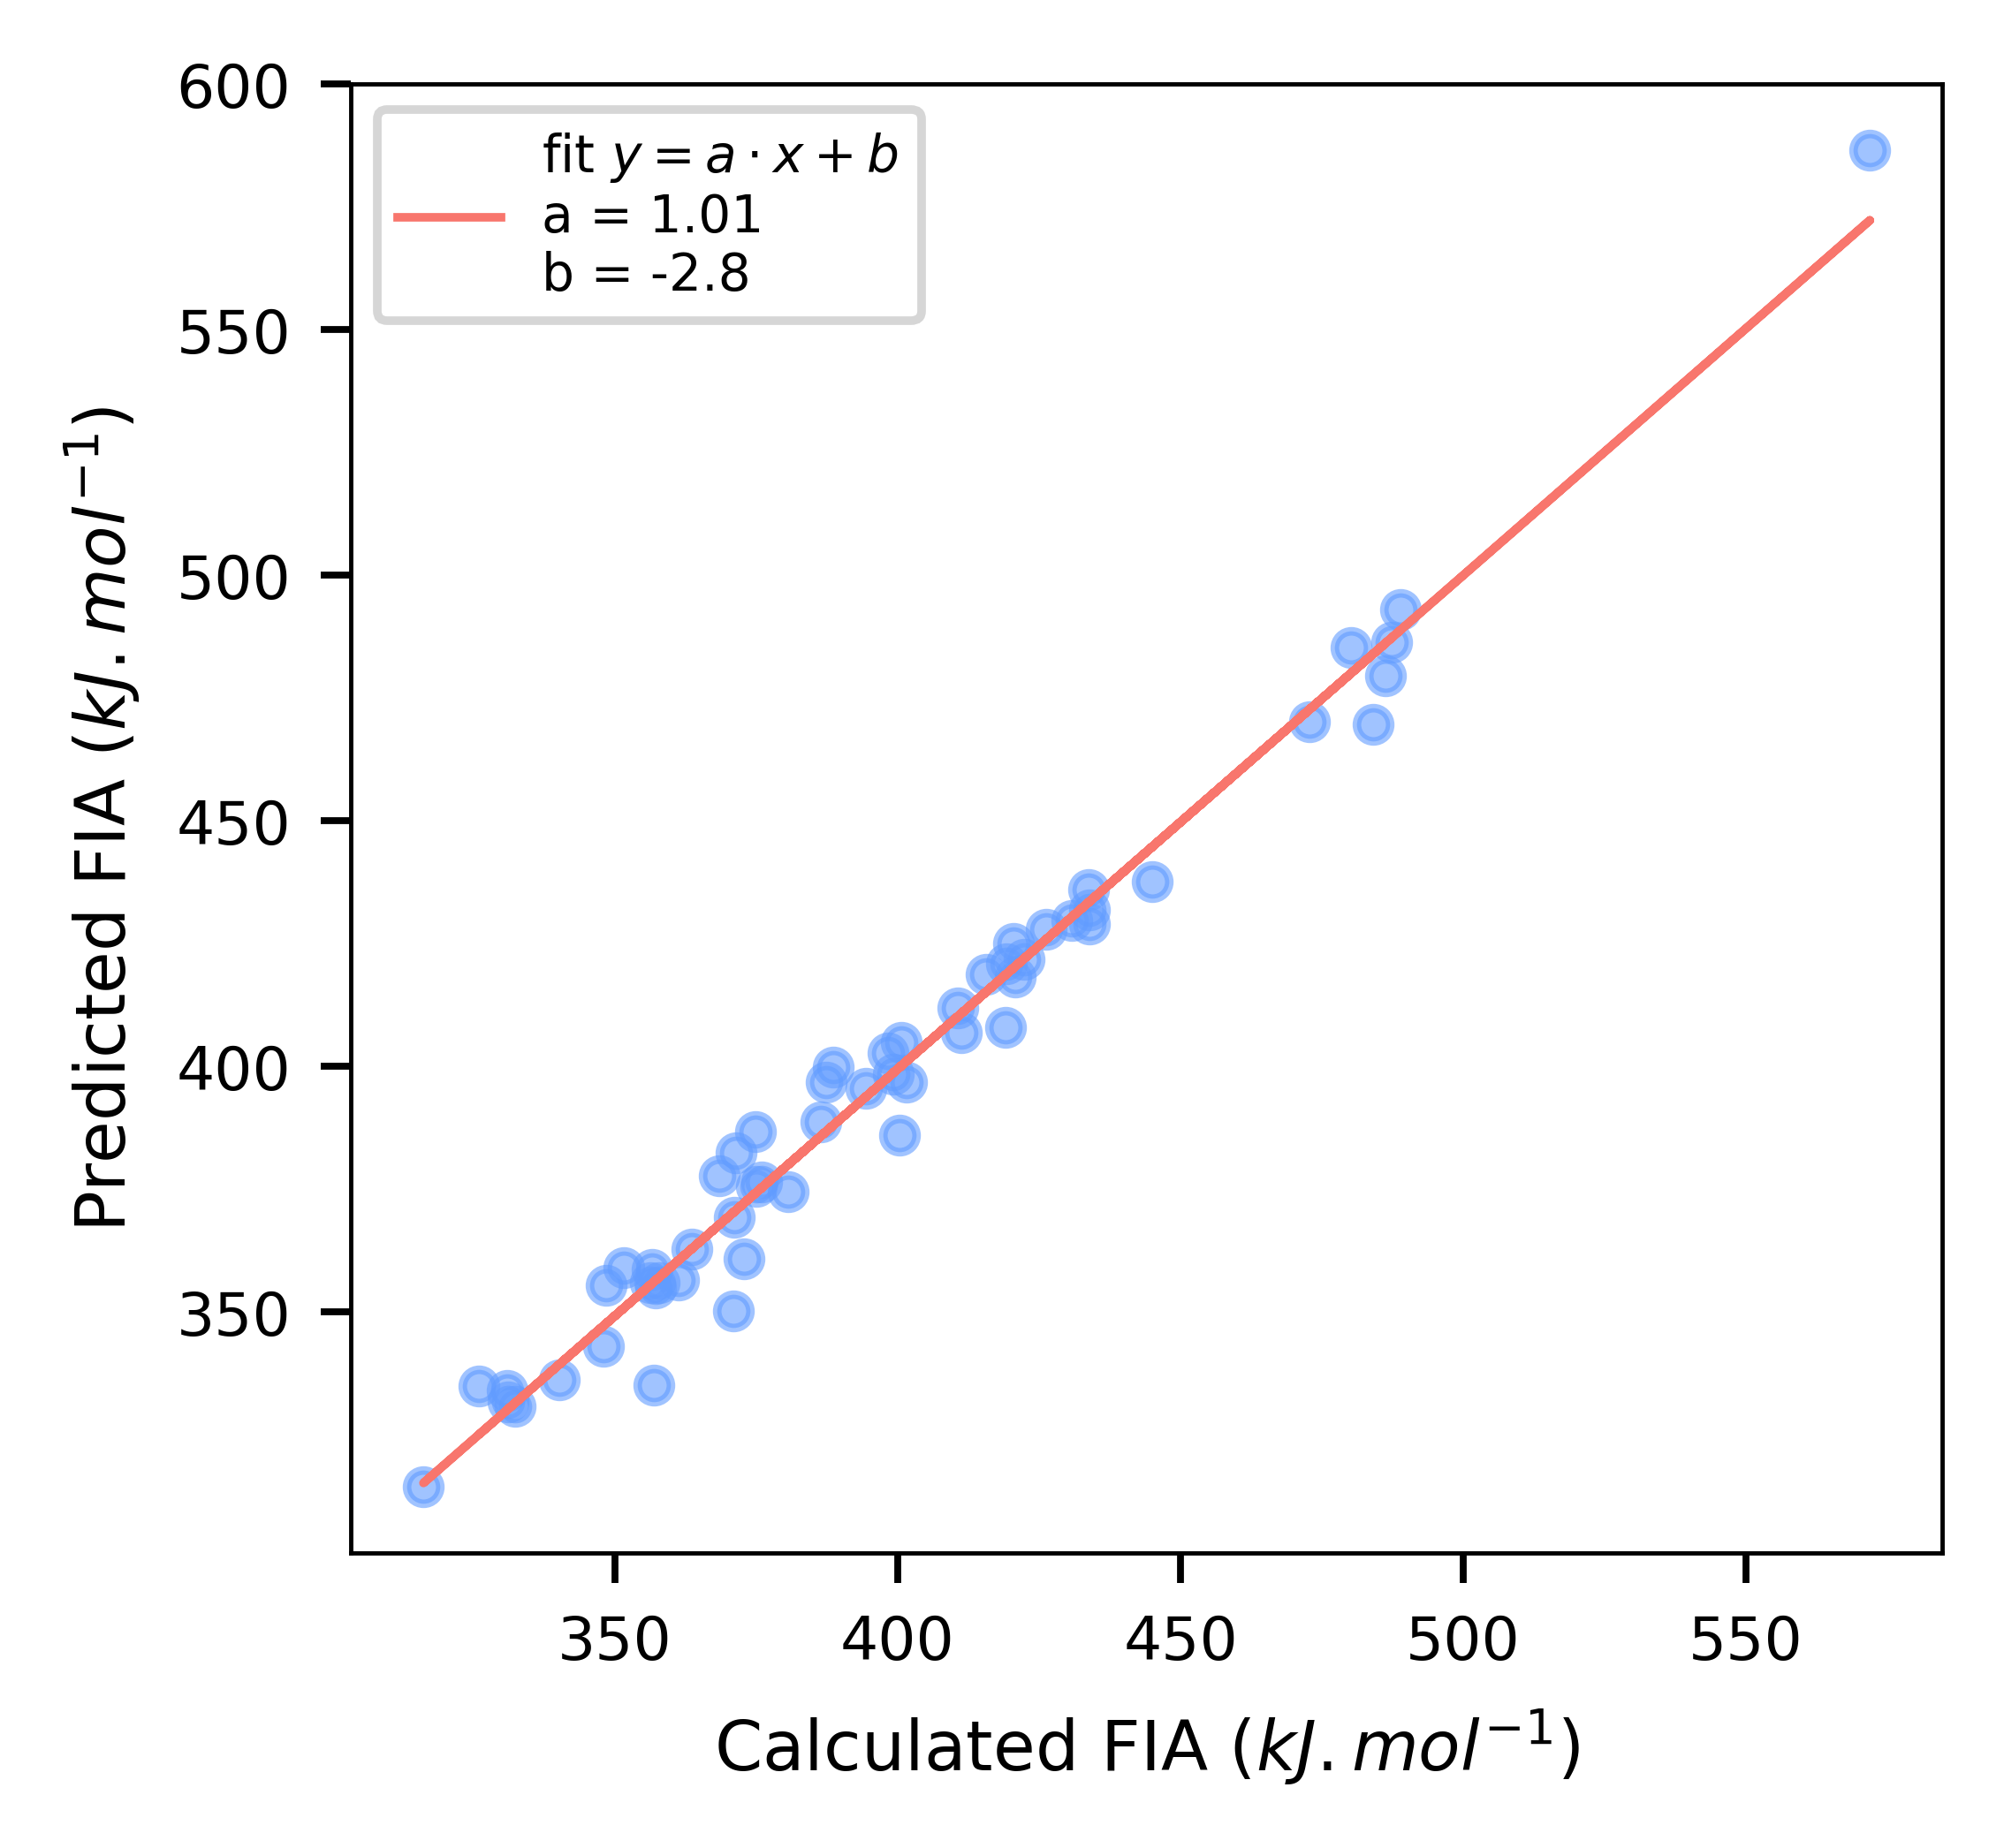

In [25]:
fig, ax = plt.subplots(figsize=(3.25, 3))

plt.ylabel('Predicted FIA ($kJ.mol^{-1}$)')
plt.xlabel('Calculated FIA ($kJ.mol^{-1}$)')


plt.scatter(x=Y_test, y=Y_pred_test, s = 15, c="#619CFF", alpha=0.6)


z = np.polyfit(Y_test, Y_pred_test, 1)
p = np.poly1d(z)
    
plt.plot(Y_test,p(Y_test),"#F8766D", label = f"fit $y=a \cdot x+b$ \na = {round(z[0],2)} \nb = {round(z[1],2)}")

#ax.set_title('B.', loc='left', fontsize =10)
plt.tight_layout()
plt.legend()
plt.show()

fig.savefig(f'../results/oracle/CV_plot_oracle_model_ONO_test_set.png', facecolor = 'white', format = 'png', transparent = True, bbox_inches='tight')

In [ ]:
pipe=make_pipeline(VarianceThreshold(),StandardScaler(), SelectKBest(f_regression, k = 126), model)

pipe.fit(X_rdkit_hammett_ONO_train,Y_train)
Y_pred_test = pipe.predict(X_rdkit_hammett_ONO_test)
MAE = mean_absolute_error(Y_test, Y_pred_test)
print('MAE on test set :', MAE)

MAE on test set : 5.391519690078086


## Predict all ONO chemical space

Generate SMILES for all possible compounds

In [31]:
all_possible_smiles = []
smi_base = 'c1(*)c(*)c(OB4N2(c3c(O4)c(*)c(*)c(*)c3))c2cc1(*)'
frags = ['N', 'O', 'Cl', 'F', 'Br', 'C', 'OC', 'N(C)C',
          '[H]',"C#N", "C(C)(C)C", "C(F)(F)F","[N+]([O-])=O"]
for frag in frags :
    L = list(smi_base)
    L[3]=L[30]= frag
    for frag2 in frags :
        L[26] = L[7] = frag2
        for frag3 in frags :
            L[46] = L[34] = frag3
            new_L = "".join(L)
            mol  = Chem.MolFromSmiles(new_L)
            smi = Chem.MolToSmiles(mol)
            all_possible_smiles.append(smi) 

In [32]:
df_all_smiles = pd.DataFrame()
df_all_smiles['SMILES']= all_possible_smiles
df_all_smiles = df_all_smiles.set_index('SMILES')
df_all_smiles.to_csv('../tables/data/all_possible_smiles_ONO.csv')

In [33]:
df_all_smiles = pd.read_csv('../tables/data/all_possible_smiles_ONO.csv').set_index('SMILES')

Featurize molecules

In [35]:
df_ONO = df_total[df_total.group =='ONO']
df = df_ONO
X_rdkit = create_descriptors(df.index, "rdkit")
X_hammett = create_descriptors(df.index, "hammett", structure = 'ONO')
X_rdkit_hammett_ONO = np.concatenate((X_rdkit, X_hammett), axis = 1)

Y_ONO = df.FIA

In [36]:
df = df_all_smiles
X_rdkit = create_descriptors(df.index, "rdkit")
X_hammett = create_descriptors(df.index, "hammett", structure = 'ONO')
X_rdkit_hammett_all_smiles = np.concatenate((X_rdkit, X_hammett), axis = 1)

#### Fit the model on existing data and predict for all smiles

In [38]:
pipe.fit(X_rdkit_hammett_ONO, Y_ONO)

Pipeline(steps=[('variancethreshold', VarianceThreshold()),
                ('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(k=126,
                             score_func=<function f_regression at 0x0000022B0385C160>)),
                ('ridge', Ridge(alpha=0.7, solver='sparse_cg', tol=1e-06))])

In [39]:
FIA_pred_all_smiles = pipe.predict(X_rdkit_hammett_all_smiles)

#### Save data

In [40]:
df_all_smiles["FIA"]= FIA_pred_all_smiles

In [42]:
df_all_smiles.to_csv('../tables/data/all_possible_smiles_FIA_ONO_v2.csv')

### Models

## Test models

>RF -10.642 (2.296)
>linear -10.116 (2.437)
>LR -7.634 (1.753)
>GB -10.475 (1.919)
>lasso -7.652 (1.603)
>EN -8.406 (1.382)
>LassoLars -21.729 (3.355)
>OMP -7.554 (1.893)
>BR -7.469 (1.622)


/home/juliette/anaconda3/envs/thesis/lib/python3.10/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
/home/juliette/anaconda3/envs/thesis/lib/python3.10/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, u

>ADR -7.393 (1.234)
>TR -8.971 (1.496)


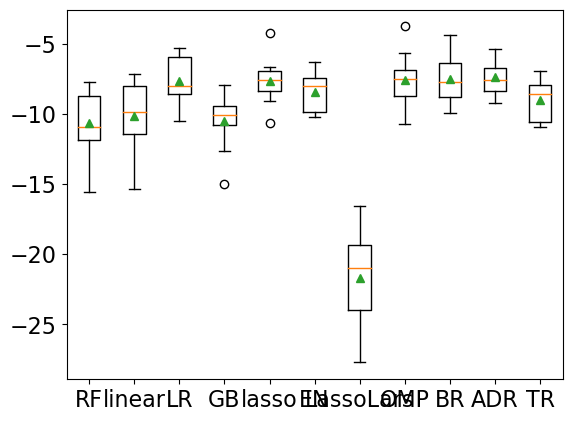

In [53]:
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, Y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

-7.39


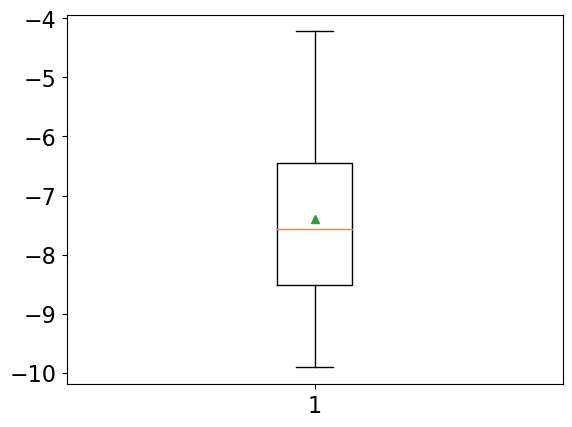

In [42]:
model = Ridge(alpha = 15, solver = 'auto')
scores = evaluate_model(model, X, Y)
plt.boxplot(scores, showmeans=True)
print(round(np.mean(scores),2))

In [95]:
reduced_features = df_X.var()[:60].index
df_X = pd.DataFrame(X)
df_X.columns = desc_names
df_X_reduced = df_X.loc[:, reduced_features]
X_reduced = np.array(df_X_reduced)

In [99]:
X_train, X_test, Y_train, Y_test = split(X,df_ONO.FIA, test_size=0.33, shuffle = True)

In [103]:
scaler = StandardScaler().fit(X)
X = scaler.transform(X)
cols_to_delete = []
for i in range(X.shape[1]):
        if X[:,i].std() == 0.0 :
            cols_to_delete.append(i)
np.delete(X, cols_to_delete, axis = 1),

(array([[-1.38692988,  0.60430867, -1.38692988, ..., -0.2236068 ,
         -0.55043459, -0.55043459],
        [-1.42473433,  0.65218288, -1.42473433, ..., -0.2236068 ,
         -0.55043459, -0.55043459],
        [-1.41939828,  0.65218288, -1.41939828, ..., -0.2236068 ,
         -0.55043459, -0.55043459],
        ...,
        [-0.25834044,  0.53156956, -0.25834044, ..., -0.2236068 ,
          1.54361004,  1.54361004],
        [-0.15794027,  0.46538686, -0.15794027, ...,  3.68951216,
          1.54361004,  1.54361004],
        [-1.44353817,  0.68694426, -1.44353817, ...,  7.60263112,
         -0.55043459, -0.55043459]]),)

## Filter features

In [8]:
X = create_descriptors(df_ONO.index, 'rdkit')
Y = df_ONO.FIA

In [10]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import r_regression

from rdkit.Chem import Descriptors

desc_names = []

for desc_name, function in Descriptors.descList :
    desc_names.append(desc_name)
    
names = desc_names

from rdkit.Chem import Descriptors
desc_names = []
for desc_name, function in Descriptors.descList :
    desc_names.append(desc_name)
    
names = desc_names

scores = list(SelectKBest(r_regression).fit(X,Y).scores_)

indexes_of_uncorr_features = []
for i,score in enumerate(scores):
    if score == float(0) :
        indexes_of_uncorr_features.append(i)
        
features_to_rm_uncorr = []
for i in indexes_of_uncorr_features :
    features_to_rm_uncorr.append(names[i])

In [11]:
df_X = pd.DataFrame(X)
df_X.columns=names

all_features = names[:]

reduced_features = all_features[:]

for feature in features_to_rm_uncorr :    
    reduced_features.remove(feature)

df_X_reduced = df_X.loc[:,reduced_features]
X_reduced = np.array(df_X_reduced)

'MAE = 7.47 +/- 0.54 \nRMSE = 9.53  +/- 0.32 \nR² = 0.949 +/- 0.01'

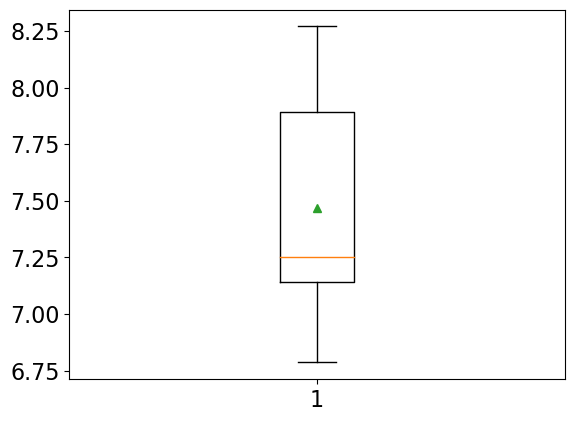

In [25]:
test_model_cross_validation(X_reduced, Y, models['LR'], n_repet=5, test_size=0.33, plot = False, boxplot = True)

## sequential feature selection

In [ ]:
pipe = Pipeline(steps=[('scaler', StandardScaler()), ('m',model)])
model = dict_models['Ridge']['quantum']
cv = RepeatedKFold(n_splits=10, n_repeats=10)

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector

sfs = SequentialFeatureSelector(estimator = pipe, n_features_to_select = "auto", 
                                tol = 0.01,  direction = "backward",
                                scoring='neg_mean_absolute_error', 
                               cv = cv, n_jobs = 1)

### Cross-validation

'MAE = 8.51 +/- 0.86 \nRMSE = 10.95  +/- 1.01 \nR² = 0.936 +/- 0.01'

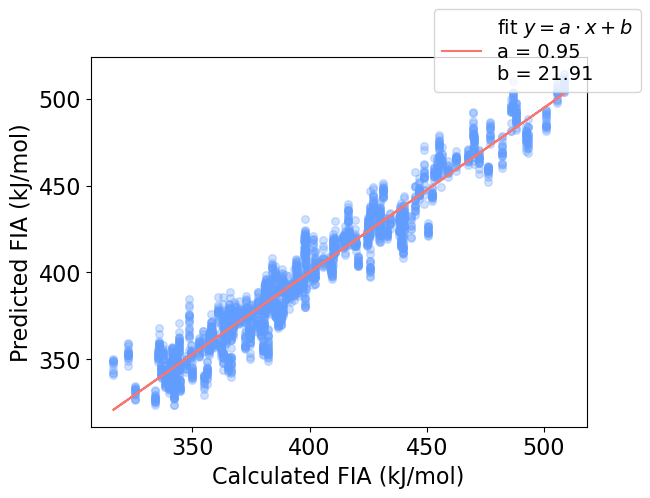

In [96]:
model = models["LR"]
test_model_cross_validation(X_reduced, df_ONO.FIA, model, n_repet= 50, test_size= 0.33, plot = True)

'MAE = 7.89 +/- 0.7 \nRMSE = 10.3  +/- 0.84 \nR² = 0.945 +/- 0.01'

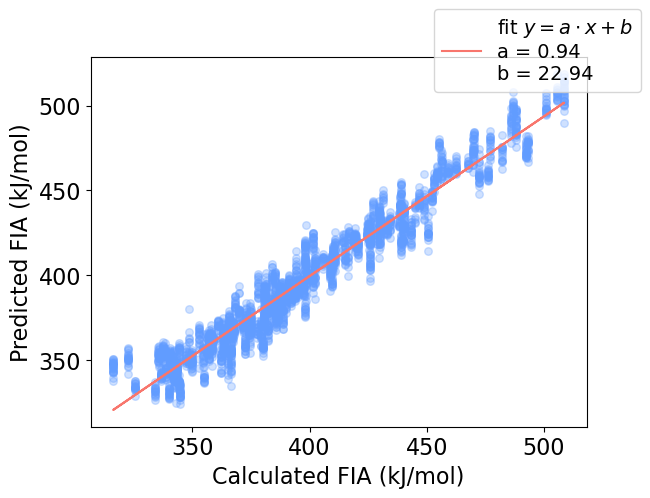

In [55]:
model = models["ADR"]
test_model_cross_validation(X, df_ONO.FIA, model, n_repet= 50, test_size= 0.33, plot = True)

'MAE = 19.62 +/- 4.51 \nRMSE = 26.26  +/- 7.65 \nR² = 0.611 +/- 0.27'

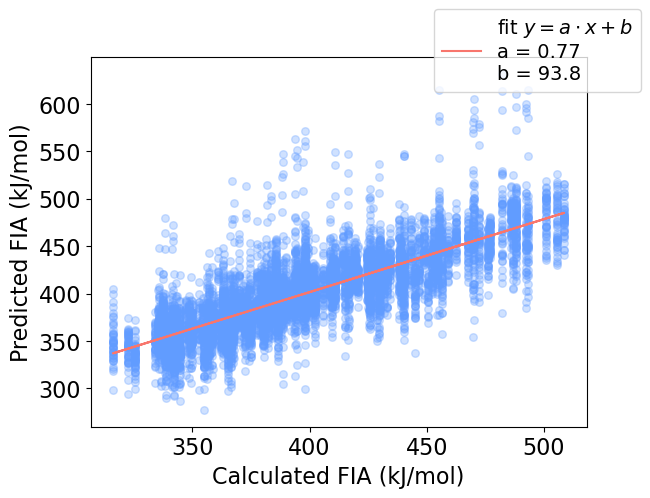

In [91]:
X = create_descriptors(df.index, 'sigman', structure = 'ONO')
model = Ridge(alpha =1.0)
test_model_cross_validation(X, df.FIA, model, n_repet= 50, test_size= 0.9, plot = True)

### Learning curves

In [80]:
from sklearn.model_selection import learning_curve

In [101]:
model = models["LR"]
X = create_descriptors(df.index, 'sigman', structure = 'ONO')

train_sizes, train_scores, test_scores = learning_curve(model, 
                                                        X, df.FIA, cv=10, 
                                                        train_sizes = np.linspace(0.1, 1.0, 10),
                                                        scoring = 'r2')

In [102]:
test_scores

array([[-2.2108568 ,  0.13160607, -1.58840664, -3.75255311, -2.55167877,
         0.46958878, -1.46257428, -0.59135008,  0.57866226, -1.10150095],
       [-0.55369802,  0.7885835 ,  0.67304888,  0.27731583,  0.65074901,
         0.65221753,  0.1728775 ,  0.35130784,  0.83438648,  0.57719199],
       [ 0.06995689,  0.81507979,  0.77409912,  0.69134642,  0.68029214,
         0.83359366,  0.60540939,  0.68419194,  0.93480743,  0.69781471],
       [ 0.55651872,  0.82275061,  0.80619528,  0.72555281,  0.64045973,
         0.70329882,  0.27784456,  0.46165692,  0.89028021,  0.69739889],
       [ 0.73381385,  0.82570077,  0.76646532,  0.64357561,  0.65757462,
         0.73444581,  0.38170434,  0.54313556,  0.90151955,  0.7480319 ],
       [ 0.75438157,  0.81458361,  0.75366693,  0.58144493,  0.7099083 ,
         0.87820089,  0.63775354,  0.71219123,  0.91034974,  0.81888109],
       [ 0.7138966 ,  0.8242591 ,  0.71900959,  0.43857089,  0.81051009,
         0.89289111,  0.76650196,  0.76684442

In [103]:
np.mean(test_scores, axis = 1)

array([-1.20790635,  0.44239805,  0.67865915,  0.65819565,  0.69359673,
        0.75713618,  0.7723397 ,  0.78321931,  0.77947516,  0.78066777])

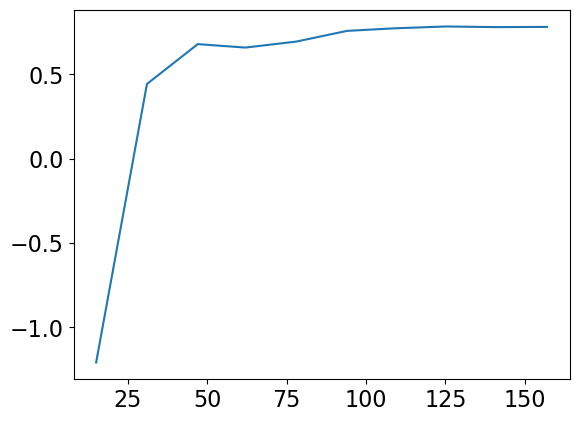

In [104]:

fig = plt.figure()
ax = fig.subplots()


plt.plot(train_sizes,np.mean(test_scores,axis=1))

In [118]:
df = df.sample(150)

In [119]:
X = create_descriptors(df.index, "sigman", structure = 'ONO')
Y = df.FIA
model = models["ADR"]

train_sizes = np.arange(5,100,5)
MAE_values_test = []
MAE_values_train = []

for size in train_sizes :
    list_MAE_test=[]
    for i in range(20):        
        X_train, X_test, Y_train, Y_test = split(X,Y, test_size=1-0.01*size)
        model.fit(X_train,Y_train)
        Y_pred_test = model.predict(X_test)
        MAE_test = mean_absolute_error(Y_test, model.predict(X_test))
        list_MAE_test.append(MAE_test)
    MAE_values_test.append(np.mean(list_MAE_test))   

In [116]:
train_sizes

array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85,
       90, 95])

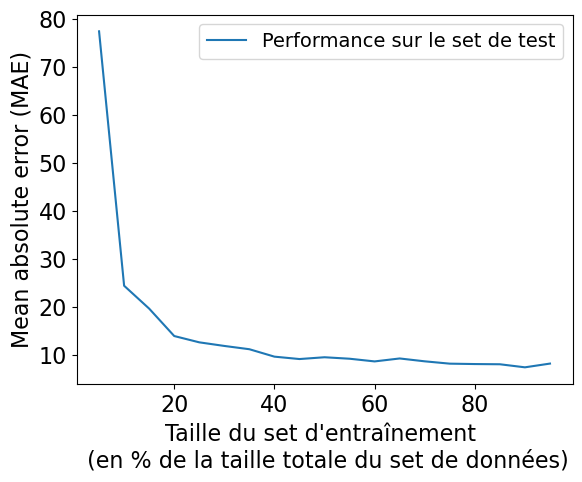

In [120]:
import matplotlib.pyplot as plt
from matplotlib import rc



fig = plt.figure()

plt.plot(train_sizes, MAE_values_test, label = "Performance sur le set de test")

plt.legend()

plt.xticks()
plt.yticks()


plt.ylabel('Mean absolute error (MAE)')
plt.xlabel("Taille du set d'entraînement \n (en % de la taille totale du set de données)")

#fig.savefig('C:\\Users\\Juliette\\Desktop\\FIA\\figures\\performances_MAE_quantum_RF.png', facecolor = 'white', format = 'png', transparent = False)

plt.show()

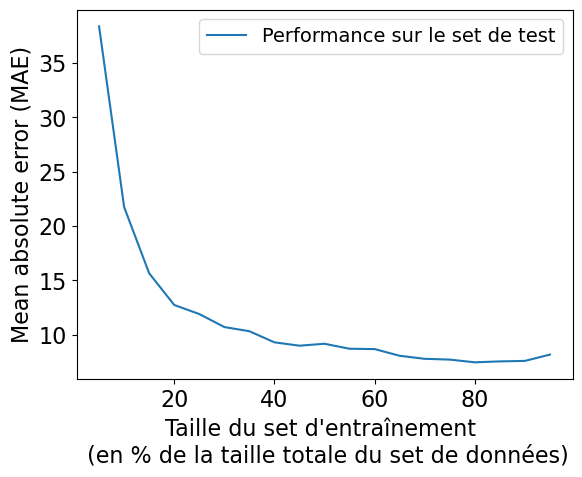

In [114]:
import matplotlib.pyplot as plt
from matplotlib import rc



fig = plt.figure()

plt.plot(train_sizes, MAE_values_test, label = "Performance sur le set de test")

plt.legend()

plt.xticks()
plt.yticks()


plt.ylabel('Mean absolute error (MAE)')
plt.xlabel("Taille du set d'entraînement \n (en % de la taille totale du set de données)")

#fig.savefig('C:\\Users\\Juliette\\Desktop\\FIA\\figures\\performances_MAE_quantum_RF.png', facecolor = 'white', format = 'png', transparent = False)

plt.show()

* Descripteurs type sigman :

modèle LR : la MAE augmente au dela d'un set de train représentant 85% du jeu de données
Pareil pour ADR
Surement de l'overfitting

## Predict the FIA for all ONO chemical space

### Create all possible smiles

In [13]:
all_possible_smiles = []
smi_base = 'c1(*)c(*)c(OB4N2(c3c(O4)c(*)c(*)c(*)c3))c2cc1(*)'
frags = ['N', 'O', 'Cl', 'F', 'Br', 'C', 'OC', 'N(C)C',
          '[H]',"C#N", "C(C)(C)C", "C(F)(F)F","[N+]([O-])=O"]
for frag in frags :
    L = list(smi_base)
    L[3]=L[30]= frag
    for frag2 in frags :
        L[26] = L[7] = frag2
        for frag3 in frags :
            L[46] = L[34] = frag3
            new_L = "".join(L)
            mol  = Chem.MolFromSmiles(new_L)
            smi = Chem.MolToSmiles(mol)
            all_possible_smiles.append(smi)   

In [15]:
df_all_smiles = pd.DataFrame()
df_all_smiles['SMILES']= all_possible_smiles
df_all_smiles = df_all_smiles.set_index('SMILES')
df_all_smiles.to_csv('../tables/data/all_possible_smiles_ONO.csv')

In [16]:
df_all_smiles = pd.read_csv('../tables/data/all_possible_smiles_ONO.csv').set_index('SMILES')

### Create descriptors

In [10]:
df = df_ONO
X_rdkit = create_descriptors(df.index, "rdkit")
X_sigman = create_descriptors(df.index, "sigman", structure = 'ONO')
X_rdkit_sigman_ONO = np.concatenate((X_rdkit, X_sigman), axis = 1)

Y_ONO = df.FIA

In [17]:
df = df_all_smiles
X_rdkit = create_descriptors(df.index, "rdkit")
X_hammett = create_descriptors(df.index, "hammett", structure = 'ONO')
X_rdkit_hammett_all_smiles = np.concatenate((X_rdkit, X_hammett), axis = 1)

### Optimised predictive model

Preprocessing step

In [ ]:
scaler = StandardScaler()
var_selector =  VarianceThreshold()

scaler.fit(X_rdkit_sigman_ONO)
X_scaled = scaler.transform(X_rdkit_sigman_ONO)

In [19]:
selector = SelectKBest(f_regression, k = 126)

In [20]:
selector.fit(X_scaled, Y_ONO)

SelectKBest(k=126, score_func=<function f_regression at 0x7f9e7c188310>)

In [50]:
np.shape(X_scaled)

(272, 126)

In [49]:
X_scaled = selector.transform(X_scaled)

In [31]:
feature_names = get_names('rdkit') + get_names('sigman')

In [33]:
len(feature_names)

244

In [39]:
selected_names = selector.get_feature_names_out(feature_names)

In [40]:
for f in feature_names :
    if f not in selected_names :
        print(f)

MinAbsEStateIndex
NumRadicalElectrons
FpDensityMorgan1
FpDensityMorgan2
BCUT2D_MWLOW
BCUT2D_LOGPLOW
Chi0n
Chi1n
Chi2n
Chi2v
Chi3n
Chi4n
PEOE_VSA11
PEOE_VSA3
PEOE_VSA5
PEOE_VSA6
PEOE_VSA7
SMR_VSA3
SMR_VSA4
SMR_VSA8
SMR_VSA9
SlogP_VSA3
SlogP_VSA5
SlogP_VSA8
SlogP_VSA9
EState_VSA11
EState_VSA3
EState_VSA5
EState_VSA6
EState_VSA8
EState_VSA9
NumAliphaticCarbocycles
NumAliphaticHeterocycles
NumAliphaticRings
NumAromaticCarbocycles
NumAromaticHeterocycles
NumAromaticRings
NumSaturatedCarbocycles
NumSaturatedHeterocycles
NumSaturatedRings
RingCount
MolMR
fr_Al_COO
fr_Al_OH
fr_Al_OH_noTert
fr_Ar_COO
fr_Ar_N
fr_Ar_NH
fr_COO
fr_COO2
fr_C_O
fr_C_O_noCOO
fr_C_S
fr_HOCCN
fr_Imine
fr_NH1
fr_N_O
fr_Ndealkylation1
fr_Ndealkylation2
fr_Nhpyrrole
fr_SH
fr_aldehyde
fr_alkyl_carbamate
fr_allylic_oxid
fr_amide
fr_amidine
fr_azide
fr_azo
fr_barbitur
fr_benzene
fr_benzodiazepine
fr_bicyclic
fr_diazo
fr_dihydropyridine
fr_epoxide
fr_ester
fr_furan
fr_guanido
fr_hdrzine
fr_hdrzone
fr_imidazole
fr_imide
fr_isoc

In [8]:
K_Fold_model_evaluation(model,X,Y,n_fold, n_repet)

In [ ]:
pipe=make_pipeline(StandardScaler(), SelectKBest(f_regression, k = 126), model)

Il faudrait réécrire cette fonction cross_val pour tracer le score calculé en KFold

'MAE = 6.69 +/- 0.62 \nRMSE = 8.96  +/- 0.82 \nR² = 0.964 +/- 0.01'

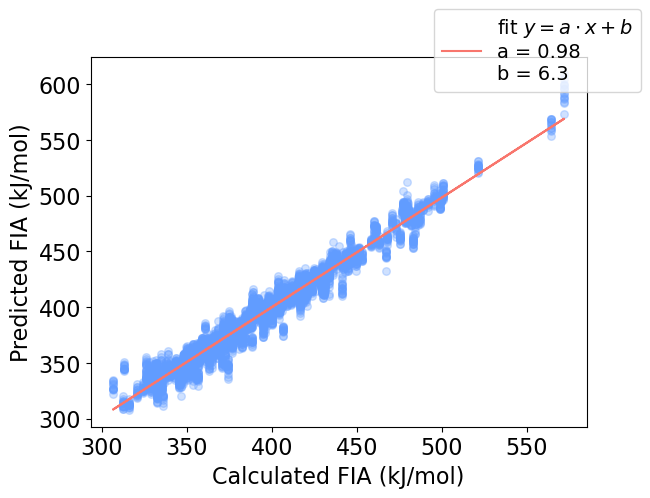

In [11]:
test_model_cross_validation(X_rdkit_sigman_ONO, Y_ONO, model, n_repet=50, test_size=0.33, plot = True, boxplot = False)

In [43]:
cv = RepeatedKFold(n_splits=10, n_repeats=200, random_state=1)
scores = cross_val_score(pipe, X_rdkit_sigman_ONO, Y_ONO, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
np.mean(scores)

-5.992794360139305

In [10]:
cv = RepeatedKFold(n_splits=10, n_repeats=200, random_state=1)
scores = cross_val_score(pipe, X_rdkit_sigman_ONO, Y_ONO, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
np.mean(scores)

-5.992792248567737

In [60]:
cv = RepeatedKFold(n_splits=10, n_repeats=200, random_state=1)
scores = cross_val_score(pipe, X_rdkit_sigman_ONO, Y_ONO, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
np.mean(scores)

-5.992794360139305

## Plot CV 

In [55]:
model = Ridge(alpha=0.7, solver='sparse_cg', tol=1e-06)

In [ ]:
def train_predict(X_train, X_test, Y_train, Y_test, model):
    scaler = StandardScaler().fit(X_train) ## descriptors are scaled
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)    
    # it is very important to fit the preprocessing only 
    #on train data to avoid data leakage
    
    f_selector = SelectKBest(f_regression, k = 126)
    f_selector.fit(X_train, Y_train) 
    X_train = f_selector.transform(X_train) 
    X_test = f_selector.transform(X_test)
    
    model.fit(X_train, Y_train)
    Y_pred_test = model.predict(X_test)
    MAE = mean_absolute_error(Y_test, model.predict(X_test))
    return(Y_pred_test,MAE)

In [68]:
total_Y_test, total_Y_pred_test, list_MAE = K_Fold_model_evaluation(model,X_rdkit_sigman_ONO,Y_ONO,
                                                                    n_fold =10, n_repet = 10)

In [69]:
np.mean(list_MAE)

6.18507396202706

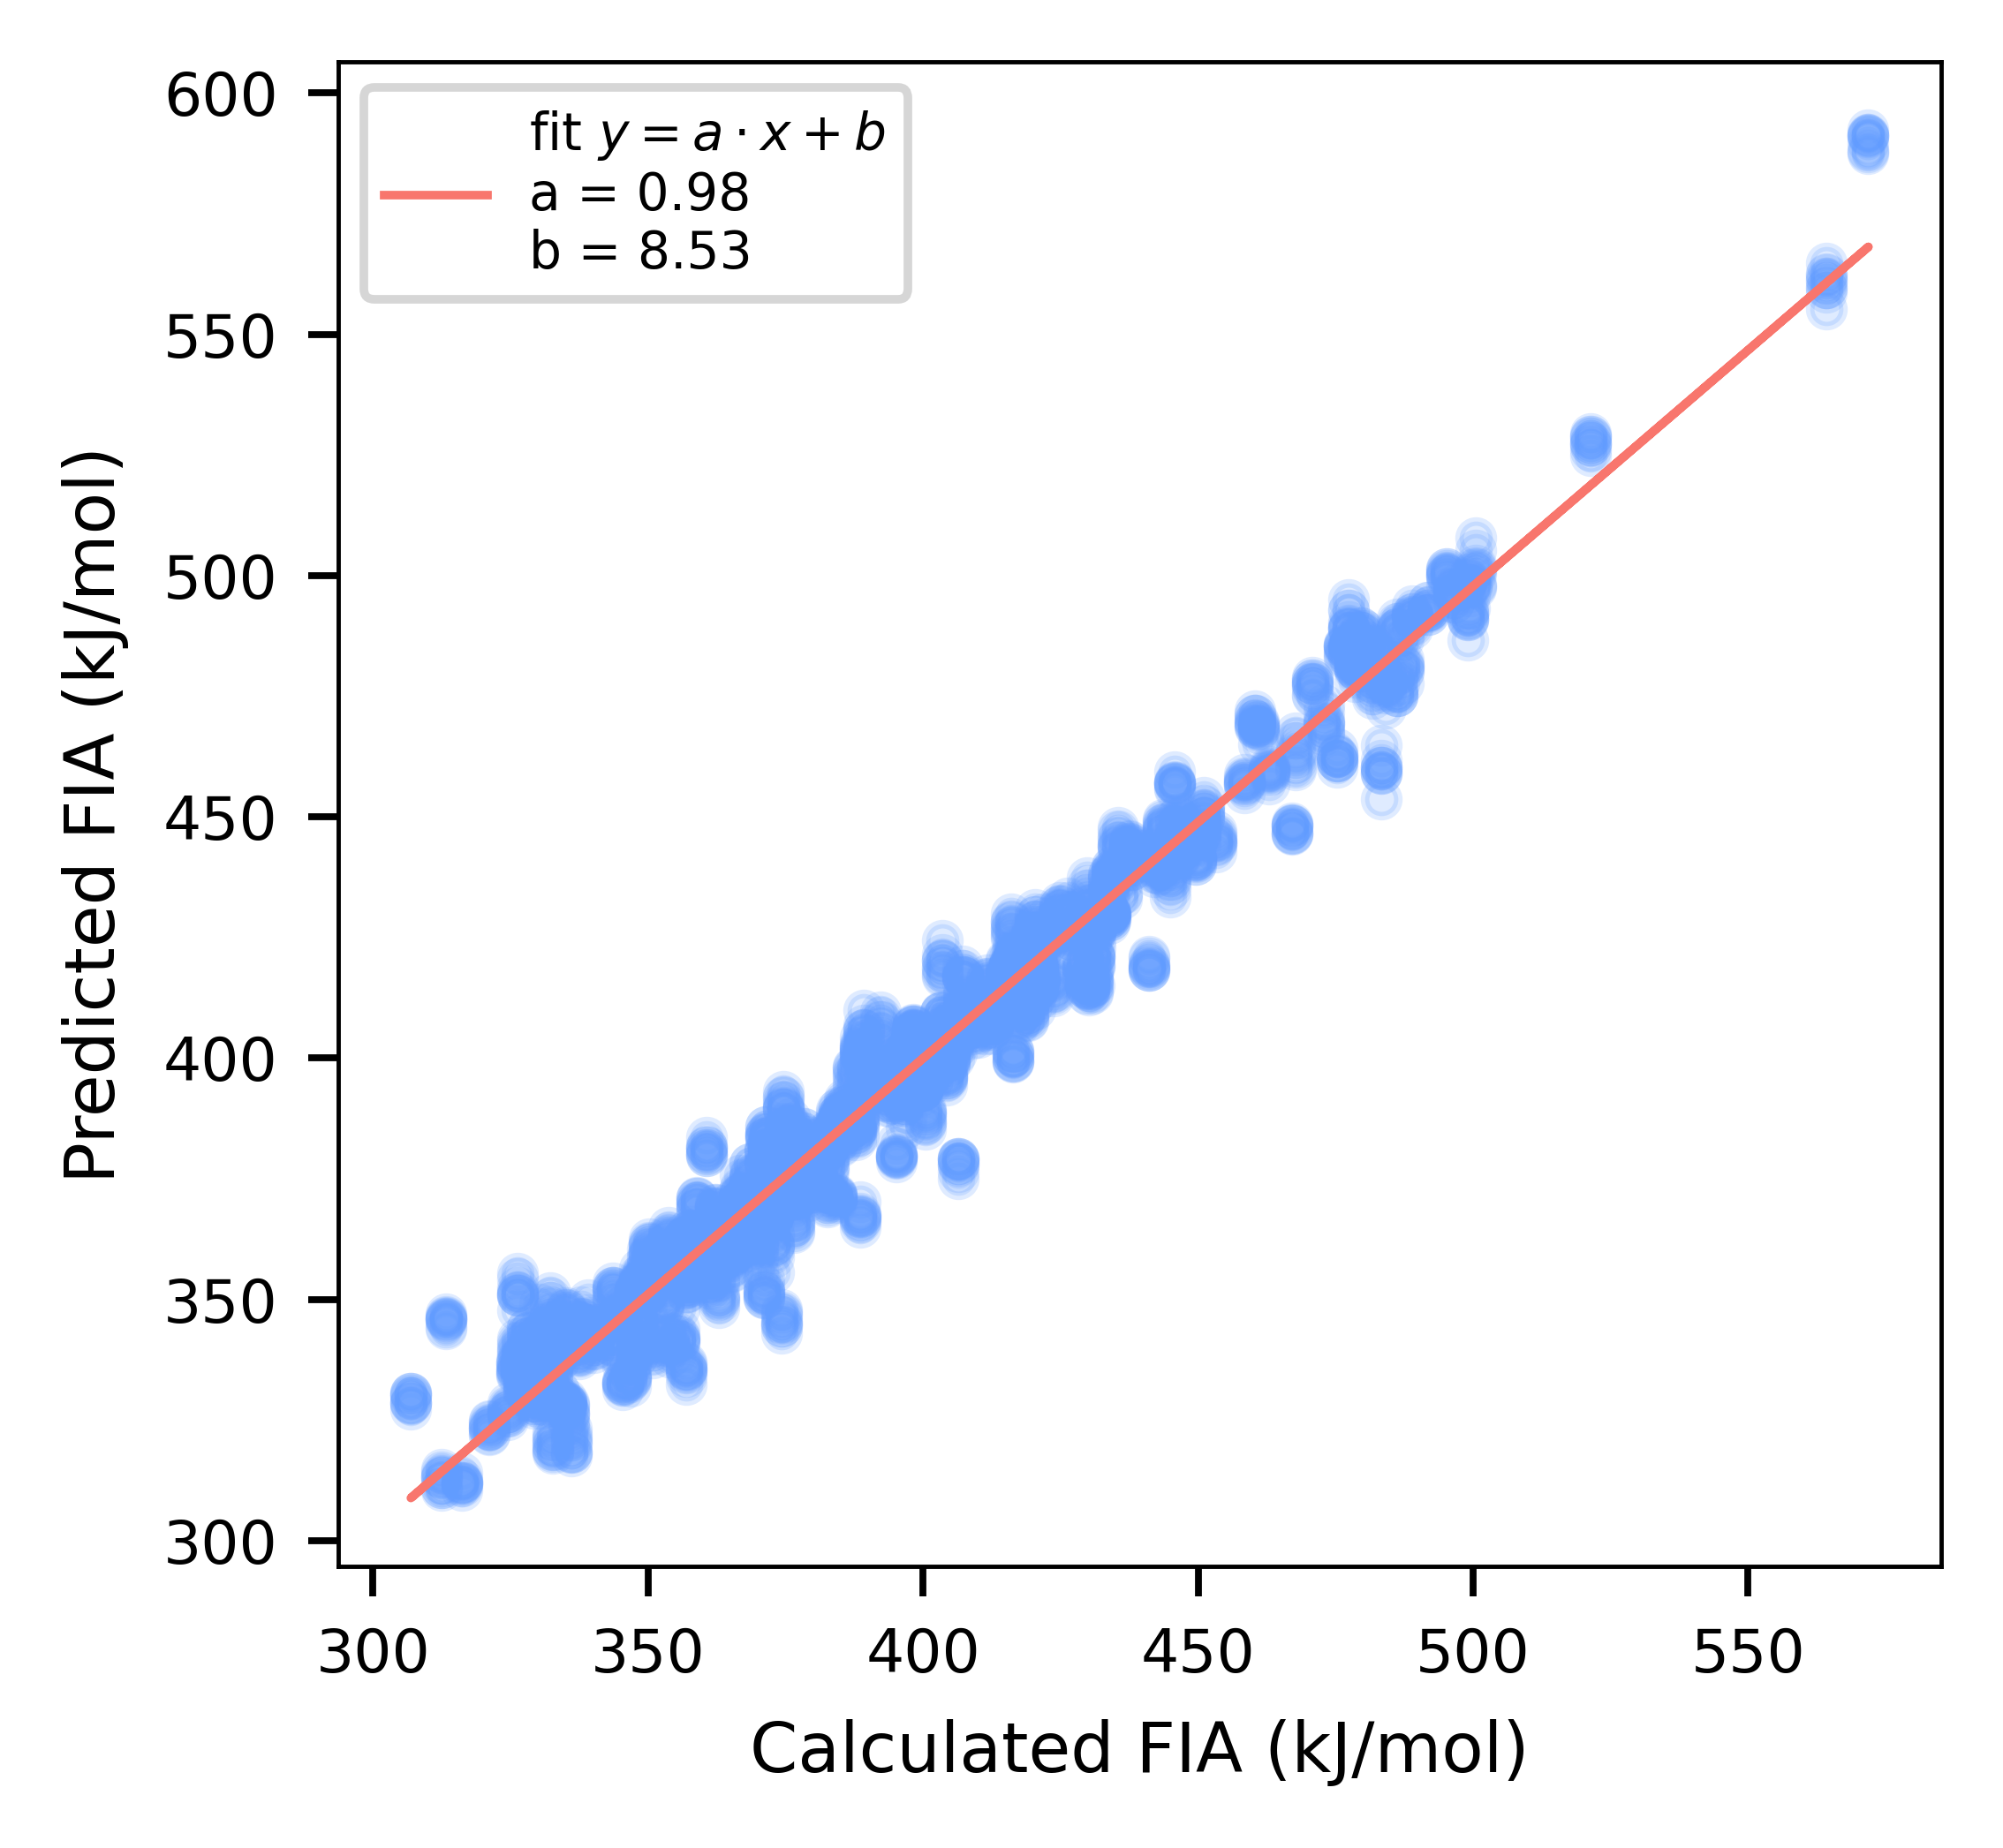

In [74]:

fig, ax = plt.subplots(figsize=(3.25, 3))

plt.ylabel('Predicted FIA (kJ/mol)')
plt.xlabel('Calculated FIA (kJ/mol)')


plt.scatter(x=total_Y_test, y=total_Y_pred_test, s = 15, c="#619CFF", alpha=0.2)


z = np.polyfit(total_Y_test, total_Y_pred_test, 1)
p = np.poly1d(z)
    
plt.plot(total_Y_test,p(total_Y_test),"#F8766D", label = f"fit $y=a \cdot x+b$ \na = {round(z[0],2)} \nb = {round(z[1],2)}")

#ax.set_title('B.', loc='left', fontsize =10)
plt.tight_layout()
plt.legend()
plt.show()

fig.savefig(f'article/figures/CV_plot_optimized_model_ONO.png', facecolor = 'white', format = 'png', transparent = True, bbox_inches='tight')

### Performances on test set only

In [21]:
model = Ridge(alpha=0.7, solver='sparse_cg', tol=1e-06)

In [17]:
X_rdkit_train = create_descriptors(df_ONO_train.index, "rdkit")
X_hammett_train = create_descriptors(df_ONO_train.index, "hammett", structure = 'ONO')
X_rdkit_hammett_ONO_train = np.concatenate((X_rdkit_train, X_hammett_train), axis = 1)

X_rdkit_test = create_descriptors(df_ONO_test.index, "rdkit")
X_hammett_test = create_descriptors(df_ONO_test.index, "hammett", structure = 'ONO')
X_rdkit_hammett_ONO_test = np.concatenate((X_rdkit_test, X_hammett_test), axis = 1)

In [18]:
Y_train = df_ONO_train.FIA
Y_test = df_ONO_test.FIA

In [ ]:
    scaler = StandardScaler().fit(X_rdkit_hammett_ONO_train) ## descriptors are scaled
    X_train = scaler.transform(X_rdkit_hammett_ONO_train)
    X_test = scaler.transform(X_rdkit_hammett_ONO_test)    
    # it is very important to fit the preprocessing only 
    #on train data to avoid data leakage
    
    f_selector = SelectKBest(f_regression, k = 126)
    f_selector.fit(X_train, Y_train)
    X_train = f_selector.transform(X_train) 
    X_test = f_selector.transform(X_test)
    
    model.fit(X_train, Y_train)
    Y_pred_test = model.predict(X_test)
    MAE = mean_absolute_error(Y_test, model.predict(X_test))

In [25]:
from sklearn.metrics import r2_score

R2= r2_score(Y_test, Y_pred_test)
R2

0.9781640773767364

In [23]:
MAE

5.391334579491825

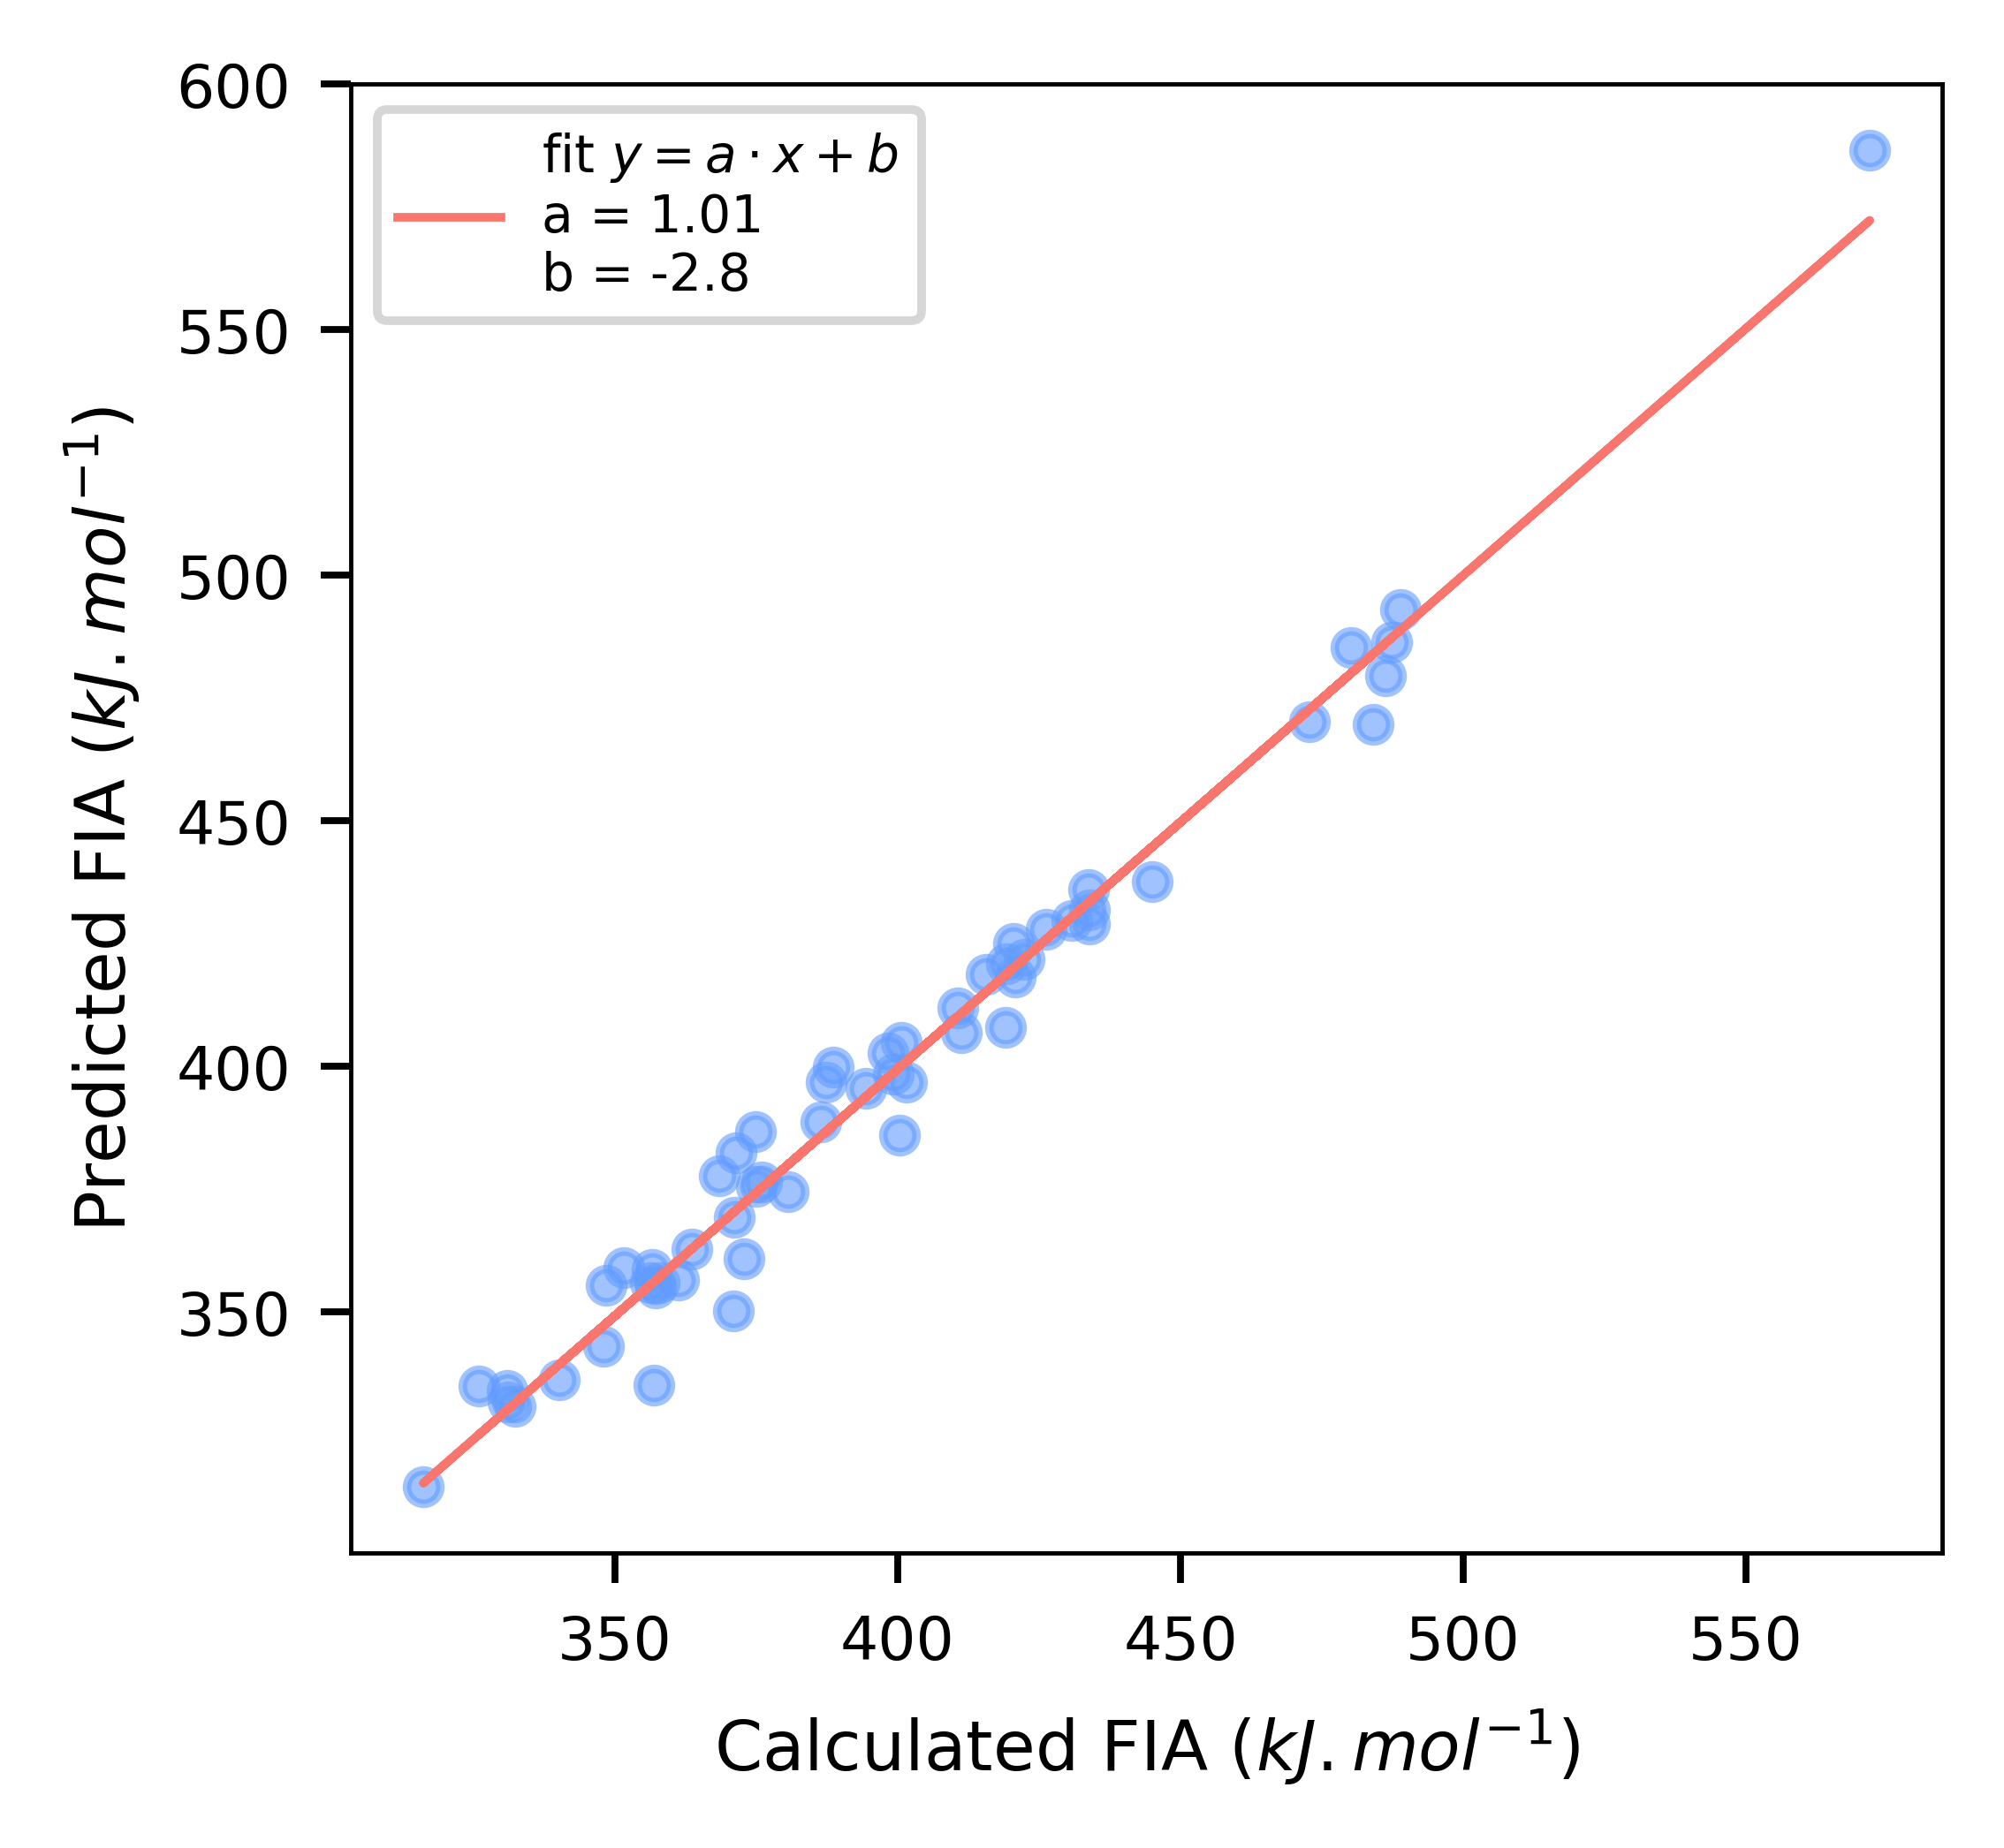

In [8]:
fig, ax = plt.subplots(figsize=(3.25, 3))

plt.ylabel('Predicted FIA ($kJ.mol^{-1}$)')
plt.xlabel('Calculated FIA ($kJ.mol^{-1}$)')


plt.scatter(x=Y_test, y=Y_pred_test, s = 15, c="#619CFF", alpha=0.6)


z = np.polyfit(Y_test, Y_pred_test, 1)
p = np.poly1d(z)
    
plt.plot(Y_test,p(Y_test),"#F8766D", label = f"fit $y=a \cdot x+b$ \na = {round(z[0],2)} \nb = {round(z[1],2)}")

#ax.set_title('B.', loc='left', fontsize =10)
plt.tight_layout()
plt.legend()
plt.show()

fig.savefig(f'article/figures/CV_plot_optimized_model_ONO_test_set.png', facecolor = 'white', format = 'png', transparent = True, bbox_inches='tight')

### Boxplot

In [13]:
evaluate_model??

In [16]:
scores = evaluate_model(model, X_rdkit_sigman_ONO_train,Y_train, n_rep = 20)

Text(0.5, 0, 'MAE distribution')

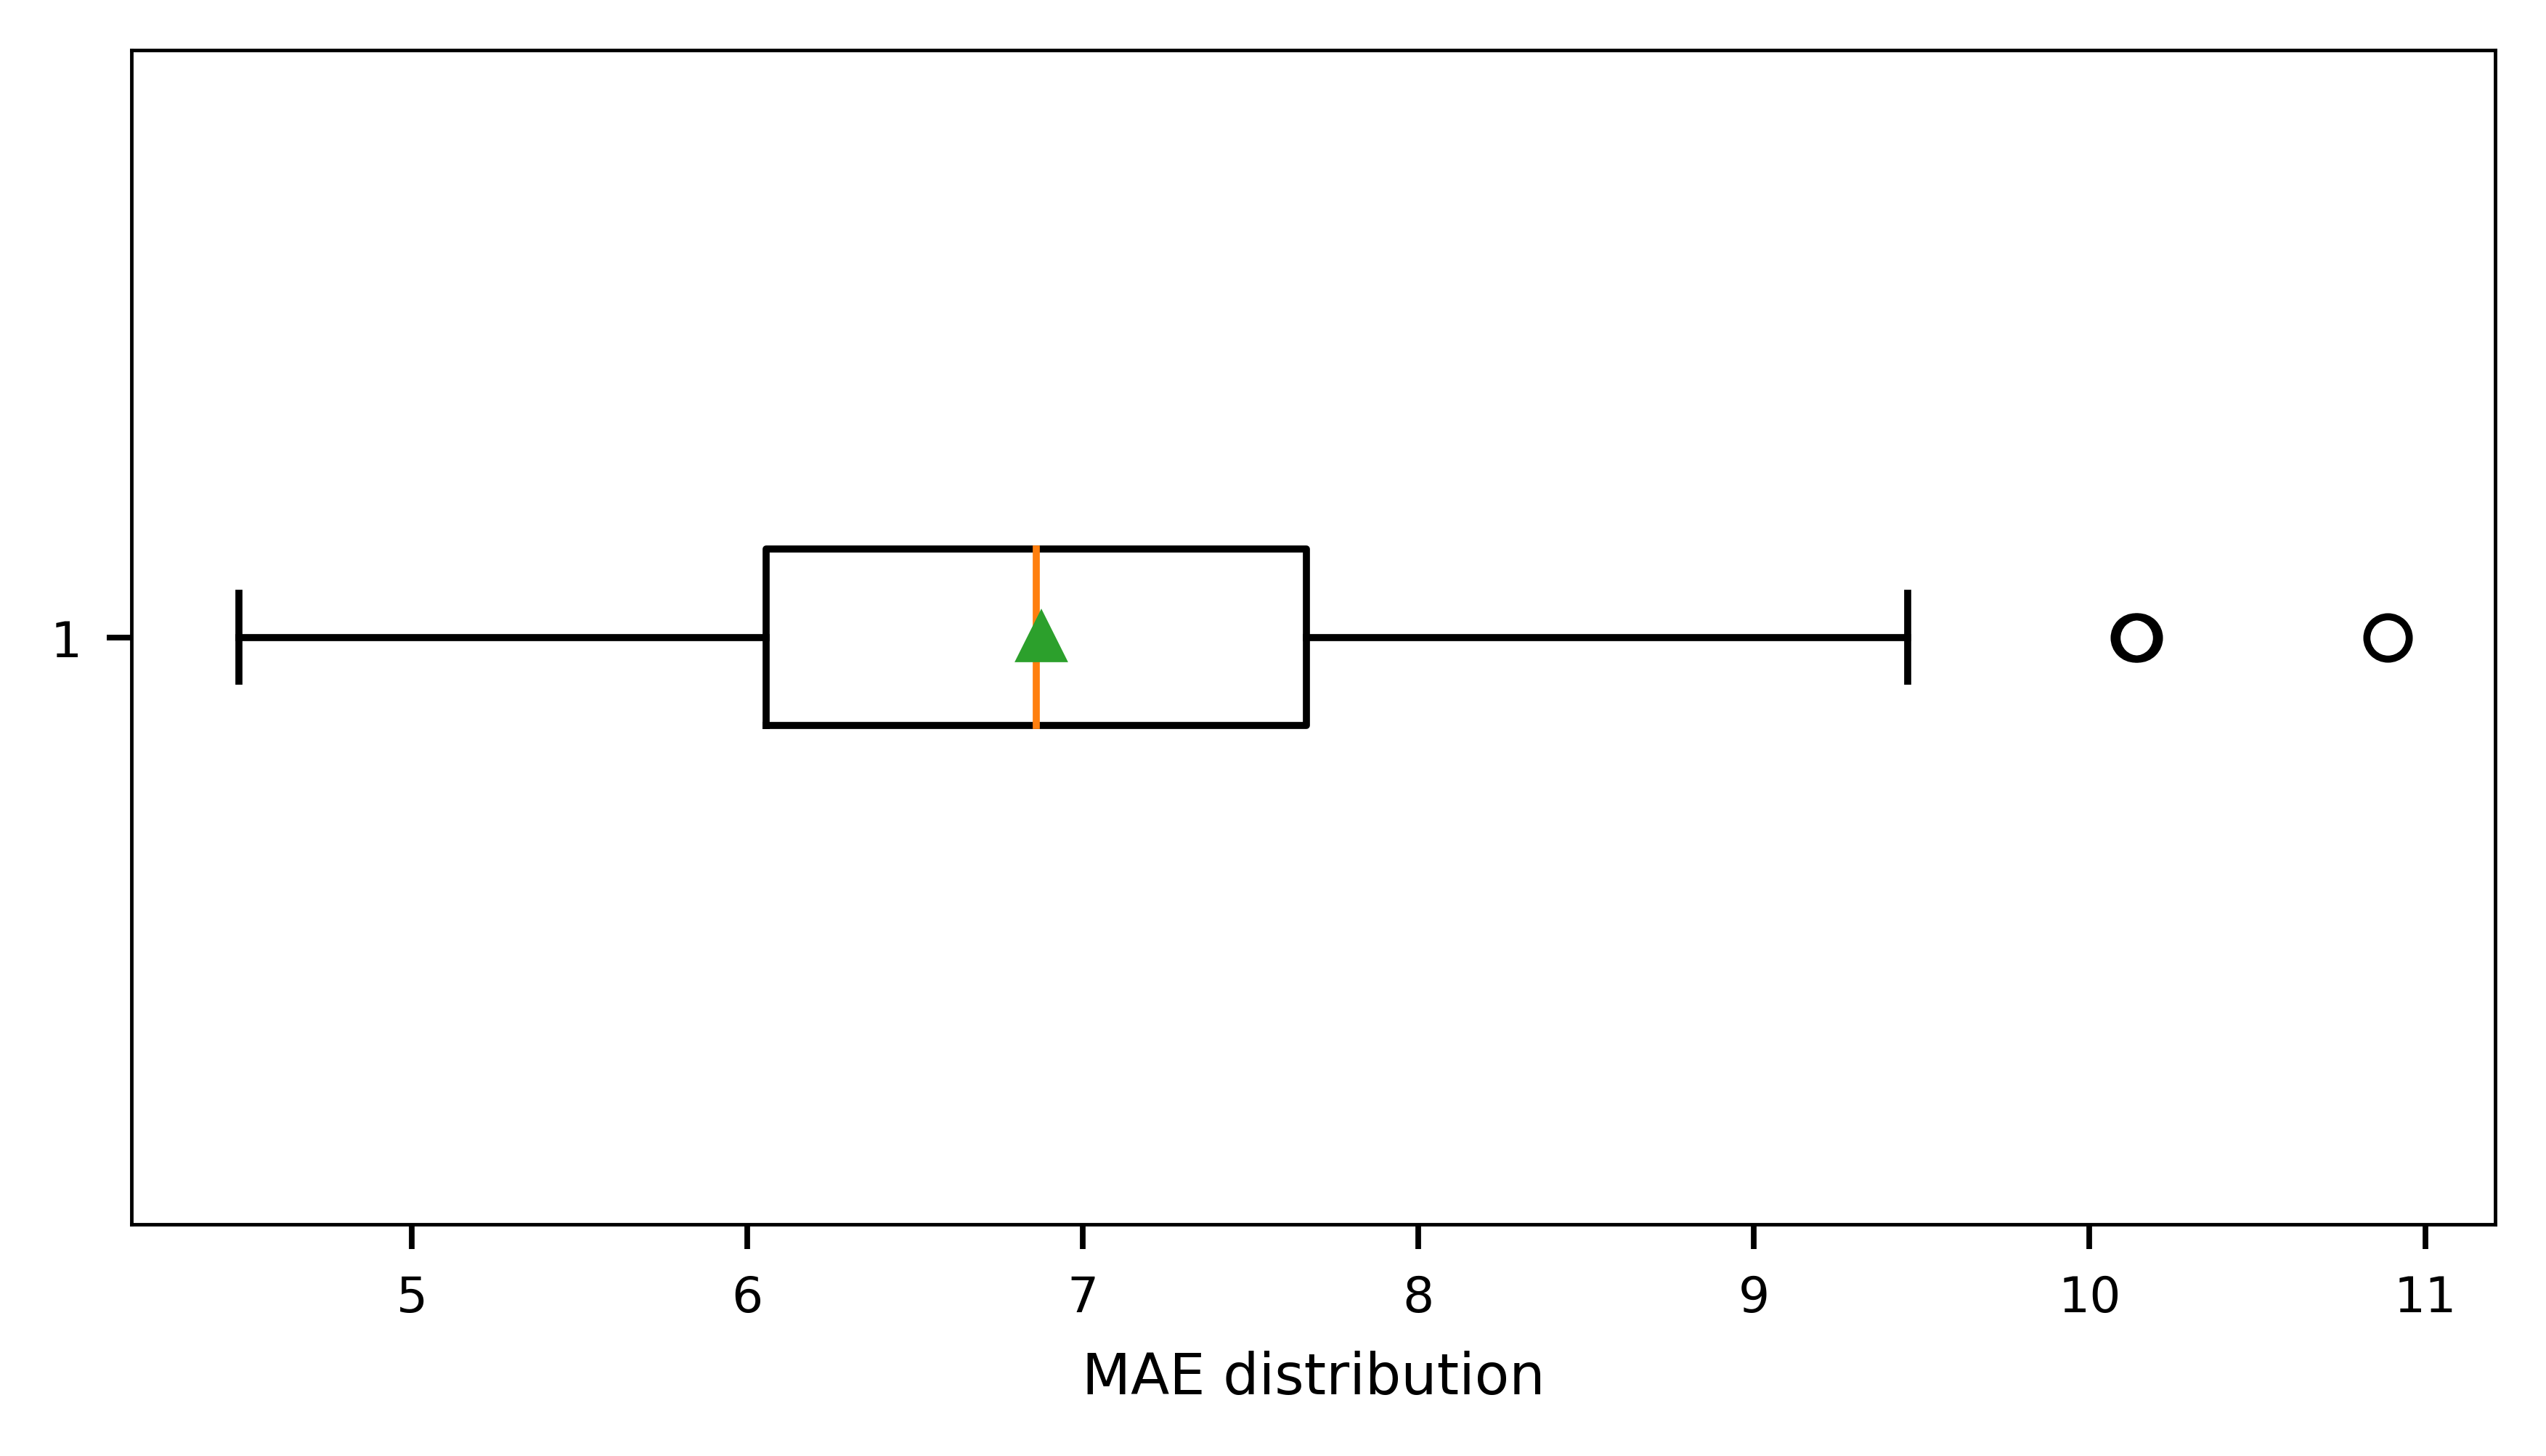

In [19]:
fig = plt.figure(figsize=(6,3))
ax = fig.subplots()

ax.boxplot(np.absolute(scores), showmeans=True, vert = False)
ax.set_xlabel('MAE distribution')

### check the model leaving small part for the test

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_rdkit_sigman_ONO, Y_ONO, test_size = 0.1, random_state=1)

In [24]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(k=126,
                             score_func=<function f_regression at 0x7f002fbcc820>)),
                ('ridge', Ridge(alpha=0.7, solver='sparse_cg', tol=1e-06))])

In [25]:
y_pred_test = pipe.predict(X_test)

5.131467962526372


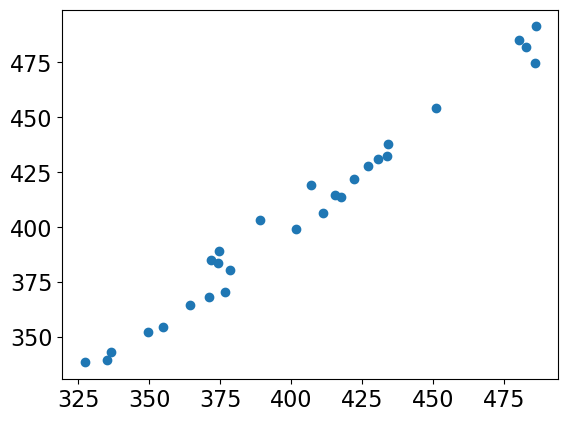

In [26]:
plt.scatter(y_test, y_pred_test)
print(mean_absolute_error(y_test, y_pred_test))

#### Just check it's ok when there is data leakage

In [27]:
y_pred = pipe.predict(X_rdkit_sigman_ONO)

4.576091834191265


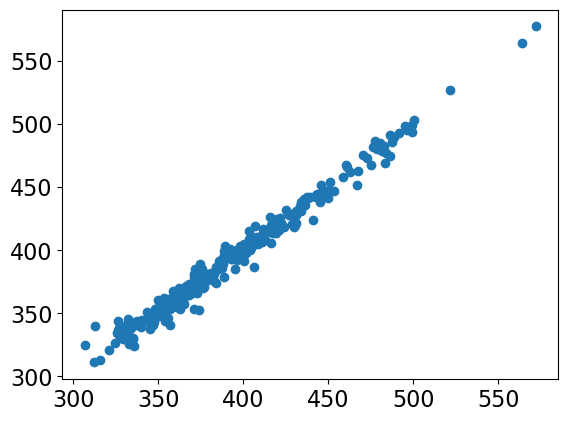

In [28]:
plt.scatter(Y_ONO, y_pred)
print(mean_absolute_error(Y_ONO, y_pred))

### Fit the model on existing data and predict for all smiles

In [76]:
pipe.fit(X_rdkit_sigman_ONO, Y_ONO)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('variancethreshold', VarianceThreshold()),
                ('selectkbest',
                 SelectKBest(k=126,
                             score_func=<function f_regression at 0x7f9e7c188310>)),
                ('ridge', Ridge(alpha=0.7, solver='sparse_cg', tol=1e-06))])

In [77]:
FIA_pred_all_smiles = pipe.predict(X_rdkit_sigman_all_smiles)

#### Save data

In [78]:
df_all_smiles["FIA"]= FIA_pred_all_smiles

In [79]:
df_all_smiles.to_csv('article/tables/all_possible_smiles_FIA_ONO.csv')